In [158]:
from typing import Dict, Tuple
import os
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [159]:
fluxes = {
    # "Slow": 5e-4,
    "Normal": 5e-3,
    "Fast": 5e-2,
    "FFast": 5e-1,
    # "FFFast": 5,
    # "FFFFast": 50,
}

folder_path_tepem = "/Users/erikweilandt/Documents/university/master_thesis/tepem/results/wave_nozzled_n10"
folder_path_elena = "/Users/erikweilandt/Library/Mobile Documents/com~apple~CloudDocs/University/MSc Mathematics Como/master_thesis/sims_elena/StokesWavy2"
results_path = "/Users/erikweilandt/Documents/university/master_thesis/tepem/results/plots"

elena_p_file_name = 'p240_newtoniano'
elena_u_file_name = 'u240_newtoniano'
tepem_p_file_name = 'p_lr'
tepem_u_file_name = 'u_hr'

In [160]:
def get_tepem_folder_names(fluxes: dict[str, float], num_slabs: int) -> dict[str,str]:
    folder_names = {speed : f"W{speed}" for speed in fluxes.keys()}
    return folder_names

def get_elena_folder_names(fluxes: dict[str, float]) -> dict[str,str]:
    folder_names = {speed : f"StokesWavy2Nozzle{speed}" for speed in fluxes.keys()}
    # folder_names = {speed : f"StokesWavy2{speed}" for speed in fluxes.keys()}
    return folder_names

elenas_folder = get_elena_folder_names(fluxes=fluxes)
tepems_folder = get_tepem_folder_names(fluxes=fluxes, num_slabs=10)

In [161]:
def read_csv_files_to_dict(folder_path: str) -> Dict[str, npt.NDArray[np.float64]]:
    data_dict: Dict[str,npt.NDArray[np.float64]] = {}

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            key = file_name[:-4]  # Remove the '.csv' extension to get the key name

            # Read the CSV file into a NumPy array and store in the dictionary
            try:
                data_dict[key] = np.loadtxt(file_path, delimiter=',', dtype=np.float64)
            except:
                data_dict[key] = np.loadtxt(file_path, dtype=np.float64)

    return data_dict

def process_subfolders(directory_path: str, folder_names: dict[str,str]) -> Dict[str, Dict[str, npt.NDArray[np.float64]]]:
    result_dict: Dict[str, Dict[str, npt.NDArray[np.float64]]] = {}
    listed_directory = os.listdir(directory_path)
    listed_directory.sort()
    print(listed_directory)
    for subfolder in listed_directory:
        if subfolder in folder_names.values():
            subfolder_path = os.path.join(directory_path, subfolder)
            if "H5" in os.listdir(subfolder_path):
                subfolder_path = os.path.join(subfolder_path, "H5")
            if os.path.isdir(subfolder_path):
                try:
                    folder_id = list(folder_names.keys())[list(folder_names.values()).index(subfolder)]  # Extract the number from the subfolder name
                    result_dict[folder_id] = read_csv_files_to_dict(subfolder_path)
                except ValueError:
                    print(f"Could not load folder: {subfolder}")


    return result_dict

In [162]:
elenas_data = process_subfolders(directory_path=folder_path_elena, folder_names=elenas_folder)
tepems_data = process_subfolders(directory_path=folder_path_tepem, folder_names=tepems_folder)

['StokesWavy', 'StokesWavy2FFFFast', 'StokesWavy2FFFast', 'StokesWavy2FFast', 'StokesWavy2Fast', 'StokesWavy2Normal', 'StokesWavy2NozzleFFFast', 'StokesWavy2NozzleFFast', 'StokesWavy2NozzleFast', 'StokesWavy2NozzleNormal']
['WFFFFast', 'WFFFast', 'WFFast', 'WFast', 'WNormal', 'output.txt']


In [163]:
def return_single_cols(full_csv: npt.NDArray[np.float64]) -> Tuple[npt.NDArray[np.float64], ...]:
    num_cols = full_csv.shape[1]
    columns: list[npt.NDArray[np.float64]] = []
    for col in range(num_cols):
        columns.append(full_csv[:,col])
    return tuple(columns)

In [164]:
def plot_pressure_overview(
        ax, 
        x_p_elena: list[npt.NDArray[np.float64]], 
        p_elena: list[npt.NDArray[np.float64]], 
        x_p_tepem: list[npt.NDArray[np.float64]], 
        p_tepem: list[npt.NDArray[np.float64]], 
        zoom_area: list[Tuple[int, ...]] = []):
    for x_p_e, p_e, x_p_t, p_t in list(zip(x_p_elena, p_elena, x_p_tepem, p_tepem)):
        pres_shape = (1,3)
        x_pressure = x_p_t[0 :: pres_shape[1] + 1]
        average_pressure = np.average(p_t.reshape(int(len(p_t)/4),-1), axis=1)
        ax.plot(x_p_e[:1200], p_e[:1200], label=f"Travaglia", color='red')
        ax.plot(x_pressure, average_pressure, label=f"average TEPEM", color='red', linestyle="dotted")
    if zoom_area:
        x1,x2,y1,y2 = zoom_area
        axins = ax.inset_axes(
            [0.1, 0.1, 0.2, 0.2],
            xlim=(x1, x2), ylim=(y1, y2))
        axins.plot(x_p_elena[:1200], p_elena[:1200], label=f"Travaglia")
        ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.set_ylabel("pressure")
    ax.set_xlabel("length in $x_1$-direction")
    ax.grid(True)
    ax.legend()

In [165]:
def plot_velo_pres_sol(
    fig,
    ax,
    p_sol: npt.NDArray[np.float64],
    x_p: npt.NDArray[np.float64],
    y_p: npt.NDArray[np.float64],
    u_x: npt.NDArray[np.float64],
    u_y: npt.NDArray[np.float64],
    x_u: npt.NDArray[np.float64],
    y_u: npt.NDArray[np.float64],
    reso: int,
):
    # fig, ax = plt.subplots()  # type: ignore
    triang = tri.Triangulation(x_p, y_p)
    # ax.triplot(triang, "bo-", lw=0.2)
    # plot only triangles with sidelength smaller some max_radius
    max_radius = 0.005
    triangles = triang.triangles

    # Mask off unwanted triangles.
    xtri = x_p[triangles] - np.roll(x_p[triangles], 1, axis=1)
    ytri = y_p[triangles] - np.roll(y_p[triangles], 1, axis=1)
    maxi = np.max(np.sqrt(xtri**2 + ytri**2), axis=1)
    triang.set_mask(maxi > max_radius)

    # ax.triplot(triang, color="indigo", lw=2.6)
    ax.tricontour(triang, p_sol, levels=10, linewidths=0.5, colors="k")  # type: ignore
    c_data = ax.tricontourf(triang, p_sol, levels=100, cmap="RdBu_r")  # type: ignore
    fig.colorbar(c_data, ax=ax)  # type: ignore
    # ax.plot(x_p, y_p, "ko")
    # arrow_lengths = np.sqrt(u_x**2 + u_y**2)
    pc = ax.quiver(  # type: ignore
        x_u[::reso],
        y_u[::reso],
        u_x[::reso],
        u_y[::reso],
        # arrow_lengths,
        # scale=0.0025,
        # scale_units="width",
        # units="width",
        # width=0.0025,
        # headlength=3,
        # headaxislength=3,
        cmap="Greys",
    )
    ax.set_xlabel("length in $x_1$-direction")
    ax.set_ylabel("width in $x_2$-direction")
    return ax

In [166]:
def get_inlet_pressures(pressure_data: npt.NDArray[np.float64], elena_data: bool = True):
    if elena_data:
        return pressure_data[0]
    average_pressure = np.average(pressure_data.reshape(int(len(pressure_data)/4),-1), axis=1)
    return average_pressure[0]

In [167]:
def sort_data_to_col_type(full_data: Dict[str, Dict[str, npt.NDArray[np.float64]]], elena_data: bool = True, pressure_data: bool = True):
    x_corrds: list[npt.NDArray[np.float64]] = []
    y_corrds: list[npt.NDArray[np.float64]] = []
    p_values: list[npt.NDArray[np.float64]] = []
    u_values: list[npt.NDArray[np.float64]] = []
    v_values: list[npt.NDArray[np.float64]] = []
    if pressure_data:
        for data in full_data.values():
            if elena_data:
                x,y,_,p = return_single_cols(full_csv=data[elena_p_file_name])
            else:
                x,y,p = return_single_cols(full_csv=data[tepem_p_file_name])
            x_corrds.append(x)
            y_corrds.append(y)
            p_values.append(p)
        return x_corrds, y_corrds, p_values
    for data in full_data.values():
        if elena_data:
            x,y,_,u,v,_ = return_single_cols(full_csv=data[elena_u_file_name])
        else:
            x,y,u,v = return_single_cols(full_csv=data[tepem_u_file_name])
        x_corrds.append(x)
        y_corrds.append(y)
        u_values.append(u)
        v_values.append(v)
    return x_corrds, y_corrds, u_values, v_values

In [168]:
x_e, y_e, p_e = sort_data_to_col_type(elenas_data)
x_t, y_t, p_t = sort_data_to_col_type(tepems_data, elena_data=False)
x_u_e, y_u_e, u_e, v_e = sort_data_to_col_type(elenas_data, pressure_data=False)
x_u_t, y_u_t, u_t, v_t = sort_data_to_col_type(tepems_data, elena_data=False, pressure_data=False)


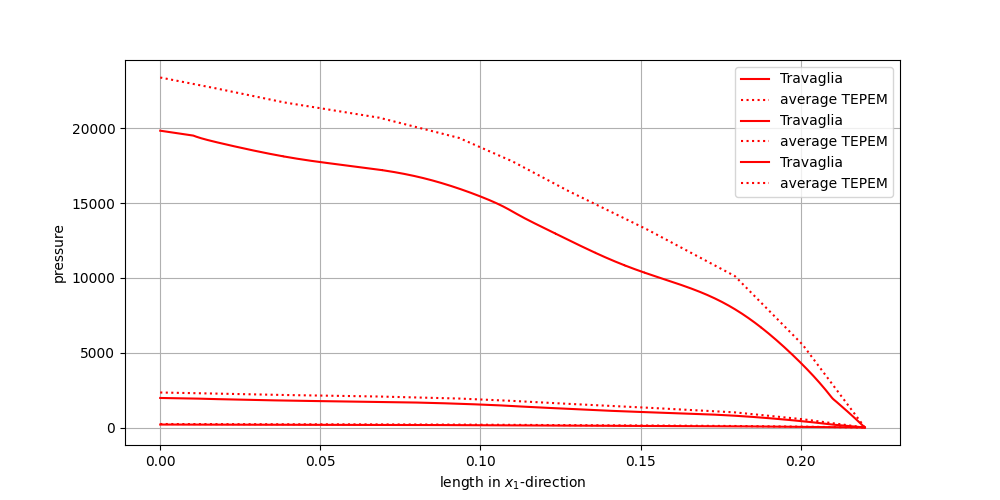

In [176]:
# fig, ax = plt.subplots(figsize=(10,5))
# plot_pressure_overview(ax=ax, x_p_elena=x_e, p_elena=p_e, x_p_tepem=x_t, p_tepem=p_t)
# fig.savefig(f"cosine_")

In [170]:
def plot_tepem_pressure(ax,x_p: npt.NDArray[np.float64], p: npt.NDArray[np.float64], zoom_area: Tuple[float, ...]):
    pres_shape = (1,3)
    x_pressure = x_p[0 :: pres_shape[1] + 1]
    linestyles = ["solid", "solid", "dashed", "dashdot"]
    labels = ["lower boundary", "lower middle", "upper middle", "upper boundary"]
    colors = ["red", "grey", "yellow", "blue"]
    x1,x2,y1,y2 = zoom_area
    axins = ax.inset_axes(
        [0.1, 0.1, 0.2, 0.2],
        xlim=(x1, x2), ylim=(y1, y2))
    for i in range(pres_shape[1] + 1):
        ax.plot(
            x_pressure,
            p[i :: pres_shape[1] + 1],
            label=f"layer {i} ({labels[i]})",
            linestyle=linestyles[i],
            color=colors[i],
        )
        axins.plot(
            x_pressure,
            p[i :: pres_shape[1] + 1],
            label=f"layer {i} ({labels[i]})",
            linestyle=linestyles[i],
            color=colors[i],
        )

    ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.set_ylabel("pressure")
    ax.set_xlabel("length in $x_1$-direction")
    ax.grid(True)
    ax.legend()

def plot_p_tepem_elena_comp(ax, x_p_elena, p_elena, x_p_tepem, p_tepem, zoom_area = []):
    pres_shape = (1,3)
    x_pressure = x_p_tepem[0 :: pres_shape[1] + 1]
    average_pressure = np.average(p_tepem.reshape(int(len(p_tepem)/4),-1), axis=1)
    ax.plot(x_p_elena[:1200], p_elena[:1200], label=f"Travaglia")
    ax.plot(x_pressure, average_pressure, label=f"average TEPEM")
    if zoom_area:
        x1,x2,y1,y2 = zoom_area
        axins = ax.inset_axes(
            [0.1, 0.1, 0.2, 0.2],
            xlim=(x1, x2), ylim=(y1, y2))
        axins.plot(x_p_elena[:1200], p_elena[:1200], label=f"Travaglia")
        ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.set_ylabel("pressure")
    ax.set_xlabel("length in $x_1$-direction")
    ax.grid(True)
    ax.legend()

In [171]:
def plot_p_field_comparison(
    x_p_elena: npt.NDArray[np.float64],
    p_sol_elena: npt.NDArray[np.float64],
    x_p_tepem: npt.NDArray[np.float64], 
    p_sol_tepem: npt.NDArray[np.float64], 
    zoom_tepem, 
    zoom_elena = []
):
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,7))
    plot_tepem_pressure(ax1, x_p_tepem,p_sol_tepem, zoom_area=zoom_tepem)
    plot_p_tepem_elena_comp(ax2, x_p_elena,p_sol_elena, x_p_tepem,p_sol_tepem, zoom_area=zoom_elena)
    plt.show()
    return fig

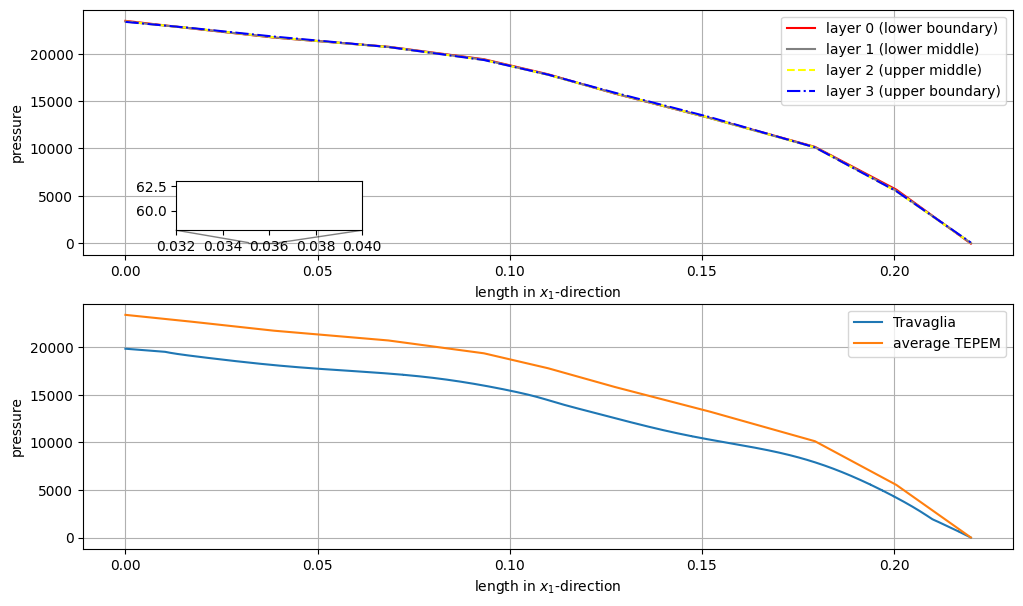

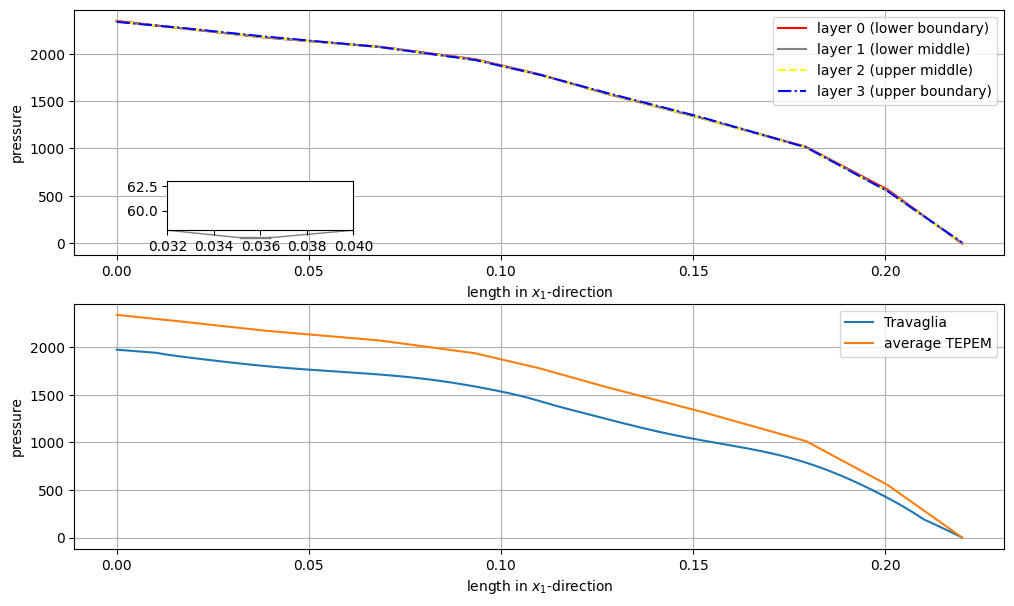

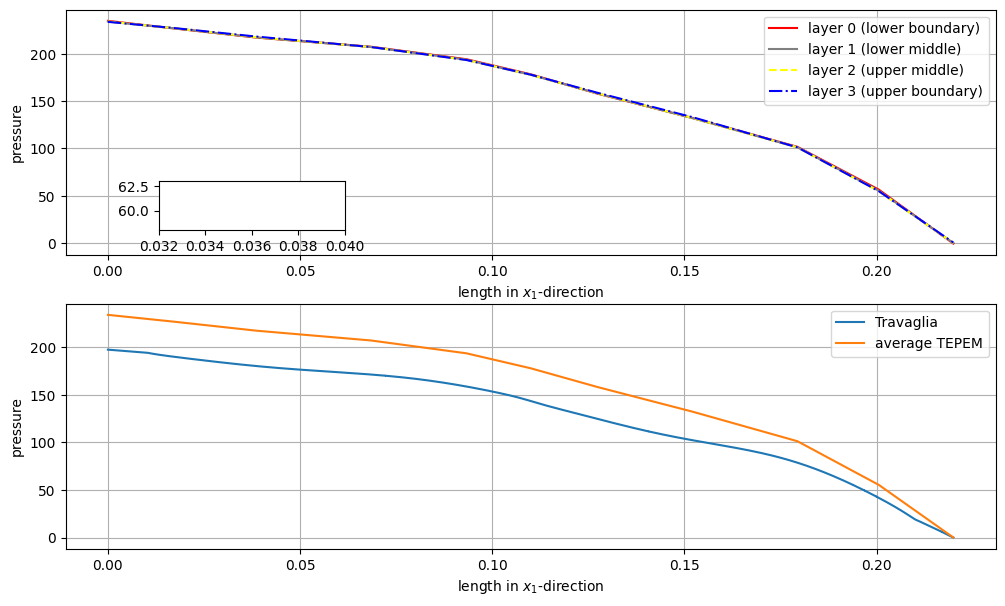

In [180]:
zoom_tepem = [
    (0.032,0.040,58,63),
    (0.032,0.040,58,63),
    (0.032,0.040,58,63),
]
i = 0
for x_elena, p_elena, x_tepem, p_tepem in list(zip(x_e, p_e, x_t, p_t)):
    fig = plot_p_field_comparison(
        x_p_elena=x_elena,
        p_sol_elena=p_elena,
        x_p_tepem=x_tepem,
        p_sol_tepem=p_tepem,
        zoom_tepem=zoom_tepem[i]
    )
    i += 1
    # fig.savefig(fname="/Users/erikweilandt/Documents/university/master_thesis/tepem/results/plots/p_wave.png", bbox_inches="tight")

In [178]:

# %matplotlib widget

%matplotlib inline
# for x_p_e, y_p_e, p_el, x_te, y_te, p_te, x_u_el, y_u_el, u_el, v_el, x_u_te, y_u_te, u_te, v_te in list(zip(x_e, y_e, p_e, x_t, y_t, p_t, x_u_e, y_u_e, u_e, v_e, x_u_t, y_u_t, u_t, v_t)):
#     fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,7))
#     plot_velo_pres_sol(fig,ax1,p_te, x_te, y_te, u_te, v_te, x_u_te, y_u_te, reso=1)
#     plot_velo_pres_sol(fig,ax2,p_el, x_p_e, y_p_e, u_el, v_el, x_u_el, y_u_el, reso=100)
#     # fig.savefig(fname="/Users/erikweilandt/Documents/university/master_thesis/tepem/results/plots/v_p_wave.png", bbox_inches="tight")
#     plt.show()



In [174]:
def get_pressure_summary(pressures_elena: list[npt.NDArray[np.float64]], pressures_tepem: list[npt.NDArray[np.float64]]):
    inlet_p_elena = []
    inlet_p_tepem = []
    for p_e, p_t in list(zip(pressures_elena, pressures_tepem)):
        inlet_p_elena.append(get_inlet_pressures(p_e))
        inlet_p_tepem.append(get_inlet_pressures(p_t, elena_data=False))
    inlet_p_elena.sort()
    inlet_p_tepem.sort() 
    inlet_e = np.array(inlet_p_elena)
    inlet_t = np.array(inlet_p_tepem)
    difference = np.absolute(inlet_e - inlet_t)
    average = inlet_e + inlet_t / 2
    rel_diff = difference / average * 100
    output = ""
    for i, value in enumerate(rel_diff):
        specific_output = f"elena: {inlet_e[i]}, tepem: {inlet_t[i]}, difference: {value}\n"
        output += specific_output
    return output



print(get_pressure_summary(p_e, p_t))

elena: 197.5185, tepem: 234.08129636862705, difference: 11.62350438055083
elena: 1975.091, tepem: 2340.8129636862714, difference: 11.626840135696852
elena: 19850.17, tepem: 23408.129636862708, difference: 11.275696138207245

